# An Adventure in Camera Calibration
> Let's learn how to use a set of known 2D and 3D point correspondances to calibrate a camera

- toc: true 
- badges: true
- comments: true
- categories: [Computer Vision,Optimization,Linear Algebra]

It's Febrary 1972, the [A300](https://en.wikipedia.org/wiki/Airbus_A300) airliner is being unviled in Toulouse, let's go on an adventure (In camera calibration!).


![An image of the Airbus A300 Final Assembly line in Toulouse](../Images/2020-2-23-An-Adventure-In-Camera-Calibration/A300.jpg)

Let's keep things interesting, and pretend that we work for an aircraft manufacturer, Norton Aircraft, headquartered in Burbank, California. Let's say we have seen this photo published in a magazine, and we want to try and learn as much about the dimensions of Airbus's new aircraft as possible. In order to do so, we will need to mathematically reconstruct the camera used to take the photo, as well as the scene itself.

Now, In this case, we are lucky, because we notice the hexagonal pattern on the floor. In particular, we notice that it's a tessellating hexagonal pattern, which can only happen if all the hexagons have identical dimensions.

While we don't know the dimensions of the hexagon, we guess that each side is approximately 1.6m long, based on the high of the people in the photo. If we assume some point on the ground, say the center of a polygon is the point 0,0, we can work out the X & Y location of each other polygon vertex we can see. Furthermore, we could also assume that the factory floor is flat and level. Hence the Z coordinate of each point is 0.

Let's spend ±5 minutes annotating the image, using an annotation tool like label me. I've generated a file, which you can find attached here: 

![An annotated image of the Airbus A300 Final Assembly line in Toulouse](../Images/2020-2-23-An-Adventure-In-Camera-Calibration/Hexagons.jpg)


Firstly, lets load in all of the x and y points:

In [1]:
import json
import numpy as np

JSON = json.loads(open('../Data/2020-2-23-An-Adventure-In-Camera-Calibration/A300.json','r').read())
polygons = {}
for shape in JSON['shapes']:
    coords = shape['label'].split(',')
    x,y = int(coords[0]),int(coords[1])
    polygons[x,y] = shape['points']    

Ok, now doing some maths, and work out the locations of each vertex of our hexagons.

In [2]:
from sklearn.neighbors import KDTree

points = []
keys = sorted(polygons.keys())

for key in keys:
    poly = polygons[key]    
    (pts_x, pts_y) = zip(*poly)
    
    pts_x = list(pts_x)
    pts_y = list(pts_y)
    
    #Magic analytic formula for working out the location of each point, based on which vertex, of which polygon it is.
    x_vertex = 0.5 * np.array([1,2,1,-1,-2,-1])
    y_vertex = 0.5 * np.array([np.sqrt(3),0,-np.sqrt(3),-np.sqrt(3),0,np.sqrt(3)])
    
    row,col = key
    x = row * 1.5 + x_vertex
    y = col * 0.5 * np.sqrt(3) + y_vertex
    
    #From before, we assume the sides of each polygon is 1.6m
    x*=1.6 #meters
    y*=1.6 #meters
    
    for idx in range(0,6):
        point = []
        i = pts_x[idx]
        j = pts_y[idx]
        X = x[idx]
        Y = y[idx]
        Z = 0.0
        points.append([i,j,X,Y,Z])
        

Now we are presented with a minor problem, in many cases, we have annotated the same point up to 3 times, where the vertices of the hexagons meet. So let's go and find points that are within 10 pixels, and then take their average. If we don't do this, then we effectively over-weight some points in the image, at the expense of others.

In [3]:
points = np.asarray(points)

tree = KDTree(points[:,0:2], leaf_size=5)

merged_indicies = []
unique_points = []
for i in range(0,points.shape[0]):
    if i not in merged_indicies:
        dist, ind = tree.query(points[i,0:2].reshape(-1, 2), k=3)
        
        indicies_to_merge = []
        for j in range(0,3):
            if dist[0][j]<10:
                indicies_to_merge.append(ind[0][j]) 
                merged_indicies.append(ind[0][j])

        mean_points = np.mean(points[indicies_to_merge,:],axis=0)
        unique_points.append(mean_points)
        
unique_points = np.asarray(unique_points)

So, now we have a bunch of 3D points, and corresponding 2D points in the photo.

Now it's time to turn to the real magic, bundle adjustment. Basically, our task at hand, is to find a camera, which best fits the data we have measured. 

Let's talk more about cameras.

> Important: There are many correct ways to model a camera mathematically. This is one way.


Mathematically, cameras are are composed of two types of parameters, *Intrinsic* and *Extrinsic*.
The *Extrinsic* parameters define the position and rotation of the camera, with respect to the origin of the points it's observing.

The *Intrinsic* parameters define the parameters of the camera itself, for example the Focal length, the location of the camera's radial center, as well as distortion induced by the lens.


The *Extrinisic* parameters are comprised of 6 degrees of freedom, given our world is 3 dimensional, and there are 3 dimensions which to rotate around. 

The *Intrinsic* parameters are more complex. There are a number of great resources, for example *Multiple View Computer Vision*, or the OpenCV documentation. However, In this case, I am assuming that the principal point, the focal length, and the radial parameters are unknown.

> Note: To be clear, I'm building on the shoulders of giants, I've heavily adapted this example from this incredible demo by *Nikolay Mayorov* which you can find here: https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html


Firstly, let's go and import a bunch of stuff we will need later

In [4]:
from __future__ import print_function

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation as Rot

%matplotlib inline

plt.rcParams["figure.figsize"] = (20,20)

In [6]:
points_2d = unique_points[:,0:2]
points_3d = unique_points[:,2:5]

print('We have {} unique points'.format(points_2d.shape[0]))


We have 51 unique points


Let's start by providing some hints to the optimiser about what the solution could be like, by putting in some reasonable starting conditions. 

We know both the image width and height, and we can assume that the principal point is in the center of the image.

I think the cameras is about 10 meters off the ground.

To make the task of optimization easier, lets rotate the camera so that it's facing directly down. This means that the points should be in front of/below it.

Let's also start off by assuming that the camera is centered above the points. It's obviously not correct, based on what we can see in the image, but it's not horrifically wrong. 

In [7]:
image_width =  2251
image_height = 1508

estimated_focal_length_px = 2000

camera_params = np.zeros(12)

r = Rot.from_euler('x', 180, degrees=True).as_rotvec()
#Rotation matrix
camera_params[0] = r[0]
camera_params[1] = r[1]
camera_params[2] = r[2]

#C
camera_params[3] = points_3d[:,0].mean()
camera_params[4] = points_3d[:,1].mean()
camera_params[5] = 10

#f,k1,k2,
camera_params[6] = estimated_focal_length_px
camera_params[7] = 0
camera_params[8] = 0
camera_params[9] = 0


#c_x,c_y
camera_params[10] = image_width/2.0
camera_params[11] = image_height/2.0

Now we come to the real magic. This function models the camera, taking points in 3D space, and converting them into points in 2D space.

There are lots of things going on here,

![Diagram of a pinhole camera](pinholeCamera.png)


Firstly, let's talk about the camera's intrinsic matrix.

Basically, it converts points from 3D space to 2D space.

\begin{equation*}
K = 
\begin{bmatrix}
f & 0 & c_{x} \\
0 & f & c_{y} \\
0 & 0 & 1 
\end{bmatrix}
\end{equation*}


We have the focal length, $f$, and the camera optical center $c_x$ and $c_y$.


Now let's talk about the camera's extrinsic matrix. 

These are the 6 degrees of freedom that describe it's position and orientation within the world. 
That's 3 degrees for the position, and 3 for the orientation. At its heart, what we are doing is simple, but confusing. 

There are so many ways to represent our setup:
1. Coordinate systems: 2D and 3D.
  * Left Handed or Right Handed?
   
2. Rotations:
  * Quaternions?
  * Proper Euler angles (6 different ways)?
  * Tait–Bryan angles (6 different ways)?
  * Rodrigues rotation formula?
  * A rotation matrix? 
3. The location of the camera in to the world. (2 Different ways).


Today we are going to use two different ways to represent the rotations, Firstly a [Rodrigues rotation vector](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula) representation, and a rotation matrix. The reason why we use two different representations is because it's easier to optimise when we have 3 degrees of freedom, rather than a naive rotation matrix which uses 9 numbers to represent 3 degrees of freedom.

R represents the orientation of the camera in the World Coordinate Frame (The frame which we use to describe our 3D points).

In python, we can use convert from the Rodrigues rotation vector to the Rotation matrix as follows:

```python
from scipy.spatial.transform import Rotation as Rot
rotation_vector = camera_params[:3]
R = Rot.from_rotvec(rotation_vector).as_matrix()
```

\begin{equation*}
R = 
\begin{bmatrix}
R_1 & R_2 & R_3 \\
R_4 & R_5 & R_6 \\
R_7 & R_8 & R_9 
\end{bmatrix}
\end{equation*}

Now, let's talk about the Project Matrix $P$ of the camera. This takes the points all the way from their location in 3D world coordinates, to pixel coordinates, assuming we have a camera without radial distortion. There are two main ways this could be formulated.

Firstly:
\begin{equation*}
P = KR[I|−C]
\end{equation*}

Secondly:
\begin{equation*}
P = K[R | t]
\end{equation*}


Where $t$ is:
\begin{equation*}
t = −RC
\end{equation*}




Let's go with the first method, where C is :

\begin{equation*}
C = 
\begin{bmatrix}
-C_X\\
-C_Y\\
-C_Z 
\end{bmatrix}
\end{equation*}


However, there is one subtlety alluded to before, which is the impact of radial distortion. Simply, the camera's lens distorts the rays of light coming in, in a non-linear way. 

We can model it using a [Taylor series](https://en.wikipedia.org/wiki/Taylor_series):

\begin{equation*}
x_c = x(1 + k_1  r^2 + k_2  r^4 + k_3 r^6)
\end{equation*}
\begin{equation*}
y_c = y(1 + k_1  r^2 + k_2 r^4 + k_3 r^6)
\end{equation*}



In python, we end up with:
```python
r = np.sqrt(np.sum(points_proj**2, axis=1)))
r = 1 + k1 \times r**2 + k2 * r**4 + k3 * r**6
points_proj *= r[:, np.newaxis]
```
    
 
    

In [8]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    #Rotation
    rotation_vector = camera_params[:3]
    R = Rot.from_rotvec(rotation_vector).as_matrix()
    
    #Camera Center
    C = camera_params[3:6].reshape(3,1)
    IC = np.hstack([np.eye(3),-C])
    RIC = np.matmul(R,IC)
    
    #Make points Homogeneous
    points = np.hstack([points,np.ones((points.shape[0],1))])
    
    #Perform Rotation and Translation
    #(n,k), (k,m) -> (n,m)
    points_proj = np.matmul(points,RIC.T)
    
    #perspective divide 
    points_proj = points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    
    f  = camera_params[6]
    
    k1 = camera_params[7]
    k2 = camera_params[8]
    k3 = camera_params[9]
    c_x = camera_params[10]
    c_y = camera_params[11]
    
    #Radial distortion
    r = np.sqrt(np.sum(points_proj**2, axis=1))
    
    x = points_proj[:,0]
    y = points_proj[:,1]
    
    points_proj[:,0] = (1 + k1 * r**2 + k2 * r**4 + k3 * r**6)*x
    points_proj[:,1] = (1 + k1 * r**2 + k2 * r**4 + k3 * r**6)*y
    
    #Make points Homogeneous
    points_proj = np.hstack([points_proj, np.ones((points_proj.shape[0],1))])
    
    K = np.asarray([[f, 0, c_x],
                    [0, f, c_y],
                    [0, 0,   1.0]])
    
    points_proj = np.dot(points_proj,K.T)
    points_proj = points_proj[:,:2]
    return(points_proj)

This section below is really well explained by [here](https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html). Basically, we are optimizing to minimise a geometric error. It's the distance between the 2D points we see, and the projection of their 3D counterparts. 

Through a process of optimization, we aim to find parameters which result in low error, which means in turn they should represent the real parameters of the camera.

In [9]:
def fun(camera_params, points_2d, points_3d):
    #Compute residuals.
    points_proj = project(points_3d, camera_params)
    return(points_proj - points_2d).ravel()

In [10]:
x0 = camera_params.ravel()

optimization_results = least_squares(fun, x0,  verbose=1, x_scale='jac', ftol=1e-4, method='lm',
                                     loss='linear',args=(points_2d, points_3d))

`ftol` termination condition is satisfied.
Function evaluations 617, initial cost 3.7406e+07, final cost 1.7290e+02, first-order optimality 5.34e+01.


Now let's go and check out the results of our optimization process.

In [11]:
camera_params = optimization_results.x

R_Rodrigues = camera_params[0:3]
C = camera_params[3:6]

r = Rot.from_rotvec(R_Rodrigues)
R_matrix = r.as_matrix()

r = Rot.from_matrix(R_matrix.T)
R_Quaternion = r.as_quat()

print('Quaternions: X: {:.3f} Y: {:.3f} Z: {:.3f} W: {:.3f} '.format(R_Quaternion[0],R_Quaternion[1],R_Quaternion[2],R_Quaternion[3]))
print('Camera position relative to the origin in (M): X: {:.2f}, Y: {:.2f}, Z: {:.2f}'.format(C[0],C[1],C[2]))

focal_length_px = camera_params[6]
k1 = camera_params[7]
k2 = camera_params[8]
k3 = camera_params[9]

c_x = camera_params[10]
c_y = camera_params[11]

print('Focal length (Pixels): {:.2f}'.format(focal_length_px))
print('CX, CY: {:.2f} {:.2f}'.format(c_x,c_y))

print('K_1, K_2, K_3 : {:.6f}, {:.6f}, {:.6f}'.format(k1,k2,k3))
print('Mean error per point: {:.2f} pixels '.format(optimization_results.cost/points_2d.shape[0]))

Quaternions: X: 0.839 Y: -0.382 Z: 0.174 W: -0.345 
Camera position relative to the origin in (M): X: -8.20, Y: -14.01, Z: 5.40
Focal length (Pixels): 1598.01
CX, CY: 1056.75 2153.95
K_1, K_2, K_3 : -0.086846, 0.195150, -0.128968
Mean error per point: 3.39 pixels 


Ok, first things first, the mean error per point is nearly 3.6 pixels, which is not great, not terrible. 
however It's clear that we have found a decent solution. However there are some interesting things going on. 
In particular, the principal point lies outside the image, which is curious to say the least. One possibility is that the image was cropped.

Now let's have a quick look at the errors for each point.

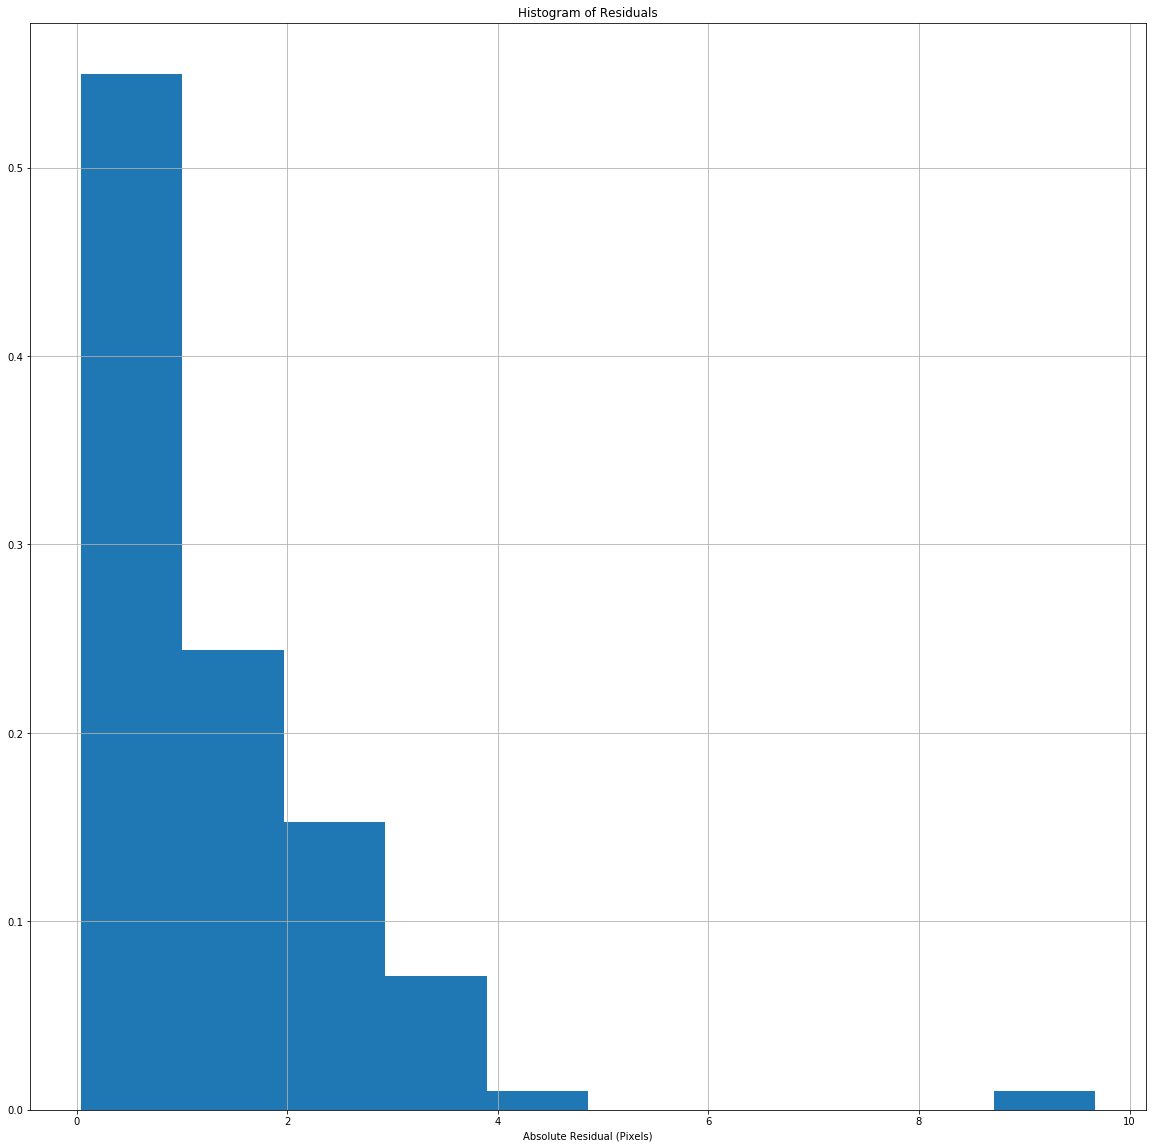

In [12]:
plt.hist(abs(optimization_results.fun),density=True)
plt.title('Histogram of Residuals')
plt.xlabel('Absolute Residual (Pixels)')
plt.grid()
plt.show()

Ok, so the histogram looks pretty good, apart from the one point with a high residual, which is probably due to sloppy labeling/annotation.

Now let's compare the points we annotated, with where they would be projected, using the camera parameters we found:

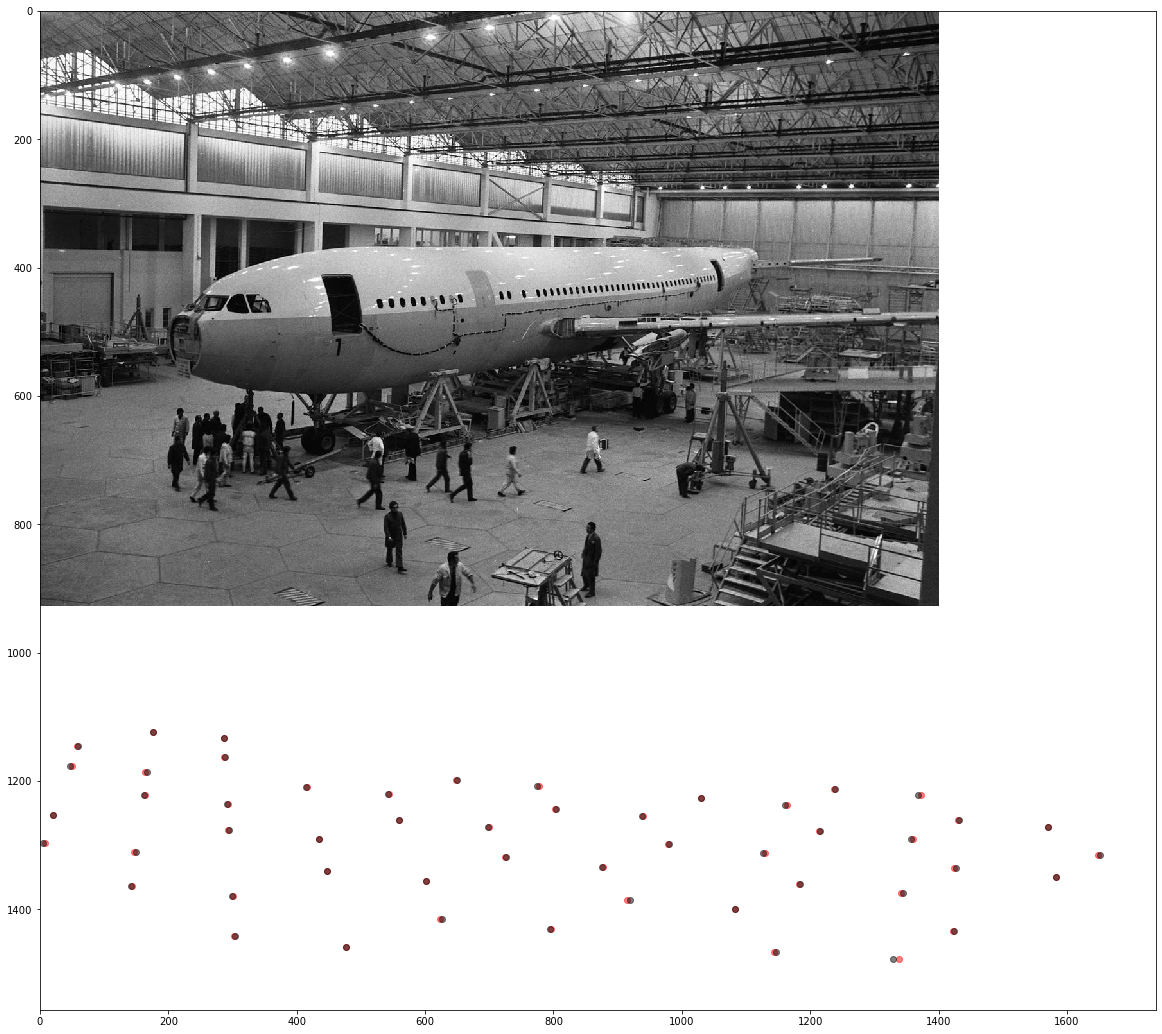

In [13]:
points_2d_proj = project(points_3d, optimization_results.x)

img = plt.imread('../Images/2020-2-23-An-Adventure-In-Camera-Calibration/A300.jpg')      
plt.imshow(img)
plt.scatter(points_2d[:,0],points_2d[:,1],label='Actual',c='r',alpha=0.5)
plt.scatter(points_2d_proj[:,0],points_2d[:,1],label='Optimised',c='k',alpha=0.5)
plt.show()

Again, this looks great.
Finally, let's overlay the hexagons on the floor, to visually build confidence in our solution.

/Users/cooke_c/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


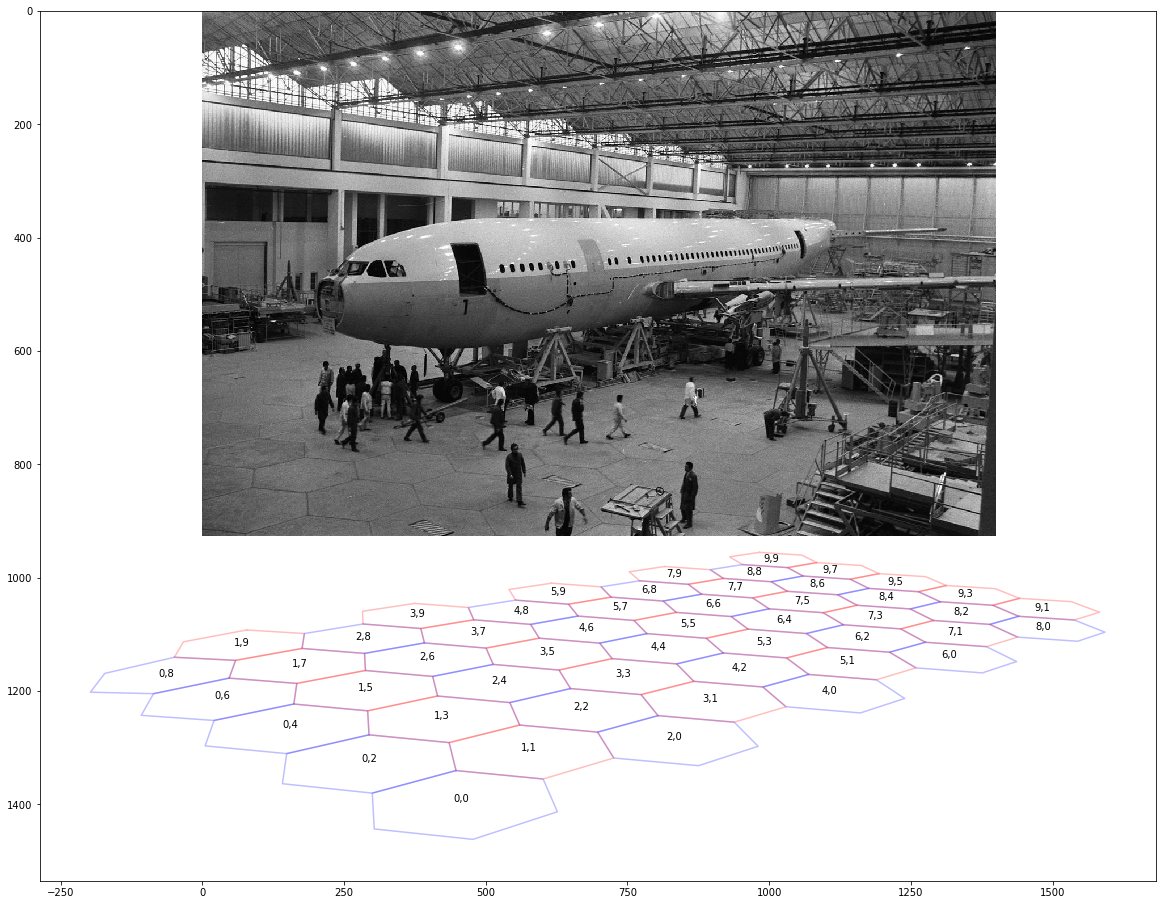

In [14]:
def plot_verticies(row,col):
    x_vertex = 0.5 * np.array([1,2,1,-1,-2,-1,1])
    y_vertex = 0.5 * np.array([np.sqrt(3),0,-np.sqrt(3),-np.sqrt(3),0,np.sqrt(3),np.sqrt(3)])

    x = row * 1.5 + x_vertex
    y = col * 0.5 * np.sqrt(3) + y_vertex

    x*=1.6
    y*=1.6

    points_3d = np.vstack([x,y,np.zeros(7)]).T
    points_2d_proj = project(points_3d, optimization_results.x)
    
    return(points_2d_proj)
    
plt.imshow(img)
for row in range(0,10,2):
    for col in range(0,10,2):
        points_2d_proj = plot_verticies(row,col)
        plt.plot(points_2d_proj[:,0],points_2d_proj[:,1],color='B',alpha=0.25)
        plt.text(np.mean(points_2d_proj[:,0]), np.mean(points_2d_proj[:,1]), str(row)+','+str(col), horizontalalignment='center',verticalalignment='center')
        

for row in range(1,11,2):
    for col in range(1,11,2):
        points_2d_proj = plot_verticies(row,col)
        plt.plot(points_2d_proj[:,0],points_2d_proj[:,1],color='R',alpha=0.25)
        plt.text(np.mean(points_2d_proj[:,0]), np.mean(points_2d_proj[:,1]), str(row)+','+str(col), horizontalalignment='center',verticalalignment='center')

         
plt.show()

Thanks for reading all the way to the end,

In the future, Let's look more about how we can extract useful information from this image, and understand how confident we can be in our solution.

Thanks to *Nikolay Mayorov* who created the awesome demo of optimization in Scipy that I built upon, please find the original code [here](https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html).

Multiple View Geometry in Computer Vision is an incredible book, that I learn more from, each time I read it. in particular, for further information see: 

> Note: Finite cameras. Page 153, Multiple View Geometry in Computer Vision (Second edition)

> Note: Minimizing geometric error. Page 176, Multiple View Geometry in Computer Vision (Second edition)